# High Value Customer Identification (Insiders)

# 0.0 Planejamento da Solução (IOT)

## Input (Entrada)

**1. Problema de Negócio**
* Selecionar os clientes mais valiosos para integrar um programa de fidelização.

**2. Conjunto de Dados**
* Vendas de um e-commerce online, durante o período de um ano (Nov 2015 - Dez 2017)

## Output (Saída)

**1. A indicação das pessoas que farão parte do programa de fidelização**
* Lista: com client_id | is_insider

**2. Relatório com as respostas para as perguntas de negócio**
* Quem são as pessoas elegíveis para participar do programa de Insiders?
* Quantos clientes farão parte do grupo?
* Quais as principais características desses clientes?
* Qual a porcentagem de contribuição do faturamento, vida dos Insiders?
* Qual a expectativa de faturamento desse grupo para os próximos meses?
* Quais as condições para uma pessoa ser elegível ao Insiders?
* Quais as condições para uma pessoa ser removida dos Insiders?
* Qual a garantia que o programa Insiders é melhor que o restante da base?
* Quais ações o time de Marketing pode tomar para aumentar o faturamento?

## Tasks (Tarefas)

**1. Quem são as pessoas elegíveis para participar do programa de Insiders?**

O que é ser elegível?

O que são clientes de maior "valor"?
- Faturamento
    * Alto ticket médio
    * Alto LTV (LifeTime Value)
    * Baixa Recência
    * Alto Basket size
    * Baixa probabilidade de Churn
    * Previsão de LTV
    * Alta propensão de compra
- Custo
    * Baixa taxa de devolução
- Experiência de compra
    * Média alta das avaliações

**2. Quantos clientes farão parte do grupo?**
- Número total de clientes
- % do grupo Insiders

**3. Quais as principais características desses clientes?**

* Escrever características dos clientes
    - Idade
    - Localização
* Escrever características do hábito de consumo
* Atributos da clusterização

**4. Qual a porcentagem de contribuição do faturamento, vida dos Insiders?**

* Faturamento total do ano
* Faturamento do grupo Insiders

**5. Qual a expectativa de faturamento desse grupo para os próximos meses?**

* LTV do grupo Insiders
* Análise de Cohort

**6. Quais as condições para uma pessoa ser elegível ao Insiders?**

* Definir a periodicidade
* A pesso precisa ser disimilar com uma pessoa do grupo

**7. Quais as condições para uma pessoa ser removida dos Insiders?**

* Definir a periodicidade
* A pesso precisa ser similar/parecida com uma pessoa do grupo

**8. Qual a garantia que o programa Insiders é melhor que o restante da base?**
* Teste A/B
* Teste A/B Bayesiano
* Teste de Hipóteses

**9. Quais ações o time de Marketing pode tomar para aumentar o faturamento?**
* Desconto
* Preferência de compra
* Frete
* Visita a empresa

## Benchamarking de soluções

### 1. Desk Research

**RFM Model**

_Recency_
* Tempo desde a última compra
* Responsividade

_Frequency_
* Tempo médio entre as transações
* Engajamento

_Monetary_
* Total gasto, faturamento
* "High-Value Purchases"

Modelo muito tradicional para empresas que tem CRM (Customer Relationship Management)

# 0.0 IMPORTS

In [17]:
import re
import pandas  as pd
import numpy   as np
import seaborn as sns
import umap.umap_ as umap

from matplotlib          import pyplot as plt
from IPython.display     import HTML
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn import cluster as c
from sklearn import metrics as m
from plotly  import express as px

## 0.1 Helper Functions

In [14]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def descriptive_analysis(num_attributes):
    # Tendência Central - média, mediana
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersão - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # Concate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
    
    return m

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load Dataset

In [4]:
data_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')
data_raw = data_raw.drop(columns=['Unnamed: 8'])

In [5]:
data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 DESCRIÇÃO DOS DADOS

In [6]:
df1 = data_raw

## 1.1 Rename columns

In [7]:
# Columns names in snake case
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 
            'invoice_date', 'unit_price', 'customer_id', 'country']

# Renaming columns
df1.columns = cols_new

## 1.2 Data dimensions

In [8]:
# Information about shape
print(f'Number of lines: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of lines: 541909
Number of columns: 8


## 1.3 Data types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [10]:
# Sum of null values
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [11]:
# Removing null values for initial analysis
df1 = df1.dropna(subset=['description', 'customer_id'])
print(f'Removed data: {1-(df1.shape[0]/data_raw.shape[0]):.2f}')

Removed data: 0.25


## 1.6 Change dtypes

In [12]:
# Changing date time
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# Changing customer id to integer
df1['customer_id'] = df1['customer_id'].astype(int)

/tmp/ipykernel_27434/2300041256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')
/tmp/ipykernel_27434/2300041256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['customer_id'] = df1['customer_id'].astype(int)


## 1.7 Descripte Statistics

In [13]:
# Separating numerical and categorical attributes
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [15]:
descriptive_analysis(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### 1.7.2 Categorical Attributes

In [29]:
cat_attributes.sample(10)

,invoice_no,stock_code,description,country
165777,550827,22382,LUNCH BAG SPACEBOY DESIGN,France
395855,571046,21851,LILAC DIAMANTE PEN IN GIFT BOX,United Kingdom
481207,577355,23046,PAPER LANTERN 9 POINT DELUXE STAR,EIRE
145074,548867,22148,EASTER CRAFT 4 CHICKS,United Kingdom
399307,571276,22142,CHRISTMAS CRAFT WHITE FAIRY,United Kingdom
112887,545901,22663,JUMBO BAG DOLLY GIRL DESIGN,United Kingdom
362971,568531,23400,SHELF WITH 4 HOOKS HOME SWEET HOME,United Kingdom
90590,544055,22295,HEART FILIGREE DOVE LARGE,United Kingdom
381259,569852,22950,36 DOILIES VINTAGE CHRISTMAS,United Kingdom
264837,C560124,84945,MULTI COLOUR SILVER T-LIGHT HOLDER,United Kingdom


### <font color='red'> Numerical Attributes - Investigating </font>

**Quantity** negativa (pode ser devolução)

**Quantity** max - muito alta

**Unit_price** com mínimo zerado (pode ser promoção)

### <font color='red'> Categorical Attributes - Investigating </font>

### **Invoice_no** com letras

In [51]:
# Invoice no
# some invoices have letters
invoices_with_letters = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

negative_quantity = invoices_with_letters[invoices_with_letters['quantity'] < 0]

if len(invoices_with_letters) == len(negative_quantity):
    print('Todos os invoices com letras apresentam quantity negativa')
    print(f'# invoices: {len(invoices_with_letters)}')
    print(f'# negative quantity: {len(negative_quantity)}')    

Todos os invoices com letras apresentam quantity negativa
# invoices: 8905
# negative quantity: 8905


### Stock code com letras

In [21]:
# Stock code
cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

# 2.0 FILTRAGEM DAS VARIÁVEIS

In [22]:
df2 = df1.copy()

# 3.0 FEATURE ENGINEERING

In [13]:
df2 = df1.copy()

In [14]:
# Creating a dataframe with unique customer ids
df_ref = pd.DataFrame({'customer_id': df2['customer_id']}).drop_duplicates(ignore_index=True)

# Creating RFM features
# Gross Revenue (quantity * unity price)
df2['gross_revenue'] = df2['quantity']*df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

# Merging dataframes
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last Day Purchase for each customer
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()

# Calculating number of days since last purchase
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']]

# Merging dataframes
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# Frequency
# Creating dataframe with number of purchases for each customer
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()

# Merging dataframes
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# Avg Ticket
df_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns=
                                                                                                     {'gross_revenue':'avg_ticket'})
# Merging dataframes
df_ref = pd.merge(df_ref, df_ticket, on='customer_id', how='left')

In [15]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


Skipped in initial analysis

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

Skipped in initial analysis

# 5.0 DATA PREPARATION

Skipped in initial analysis

# 6.0 FEATURE SELECTION

Skipped in initial analysis

# 7.0 HYPERPARAMETER FINE-TUNNING 

In [16]:
df7 = df_ref.drop(columns=['customer_id'])

In [17]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1 Within-Cluster Sum of Square (WSS)

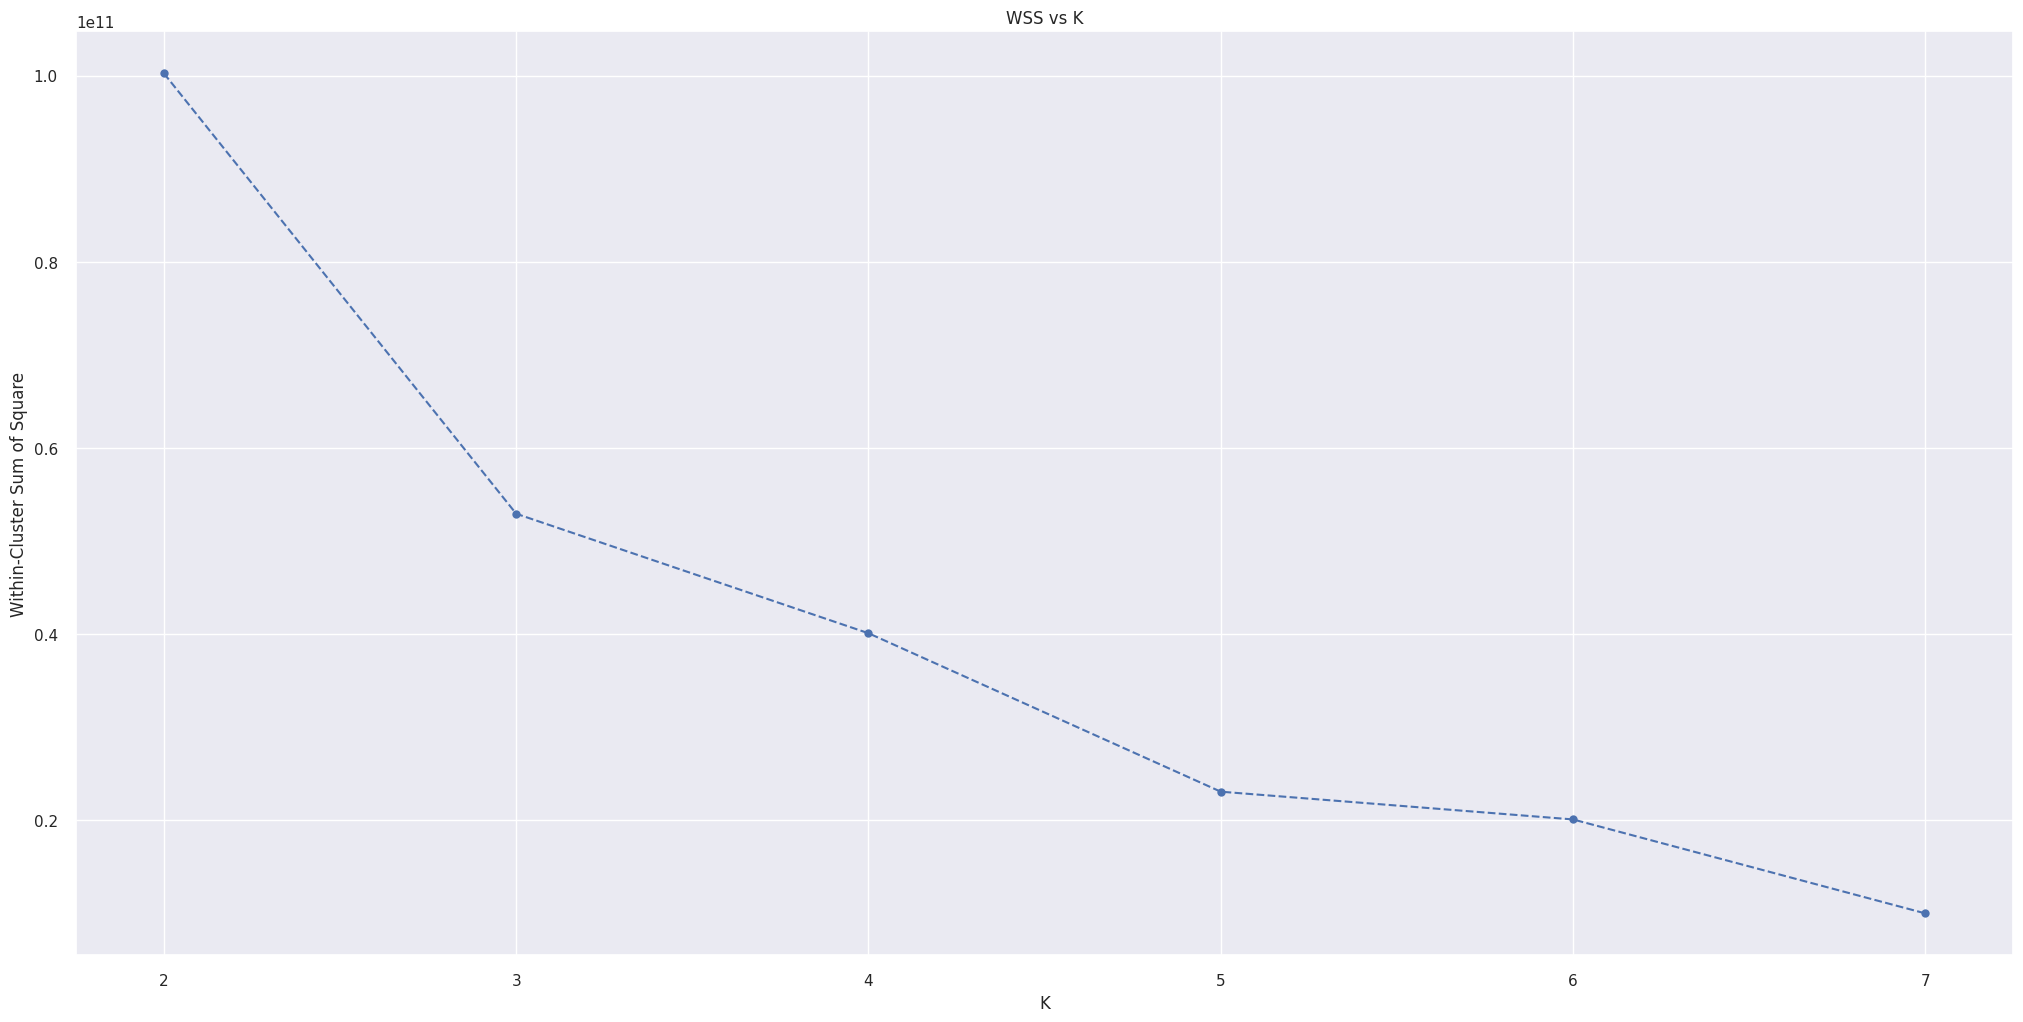

In [18]:
wss = []
for k in clusters:
    # Model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    # Model training
    kmeans.fit(df7)
    
    # Validation
    wss.append(kmeans.inertia_)
    
# Ploting wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('WSS vs K');

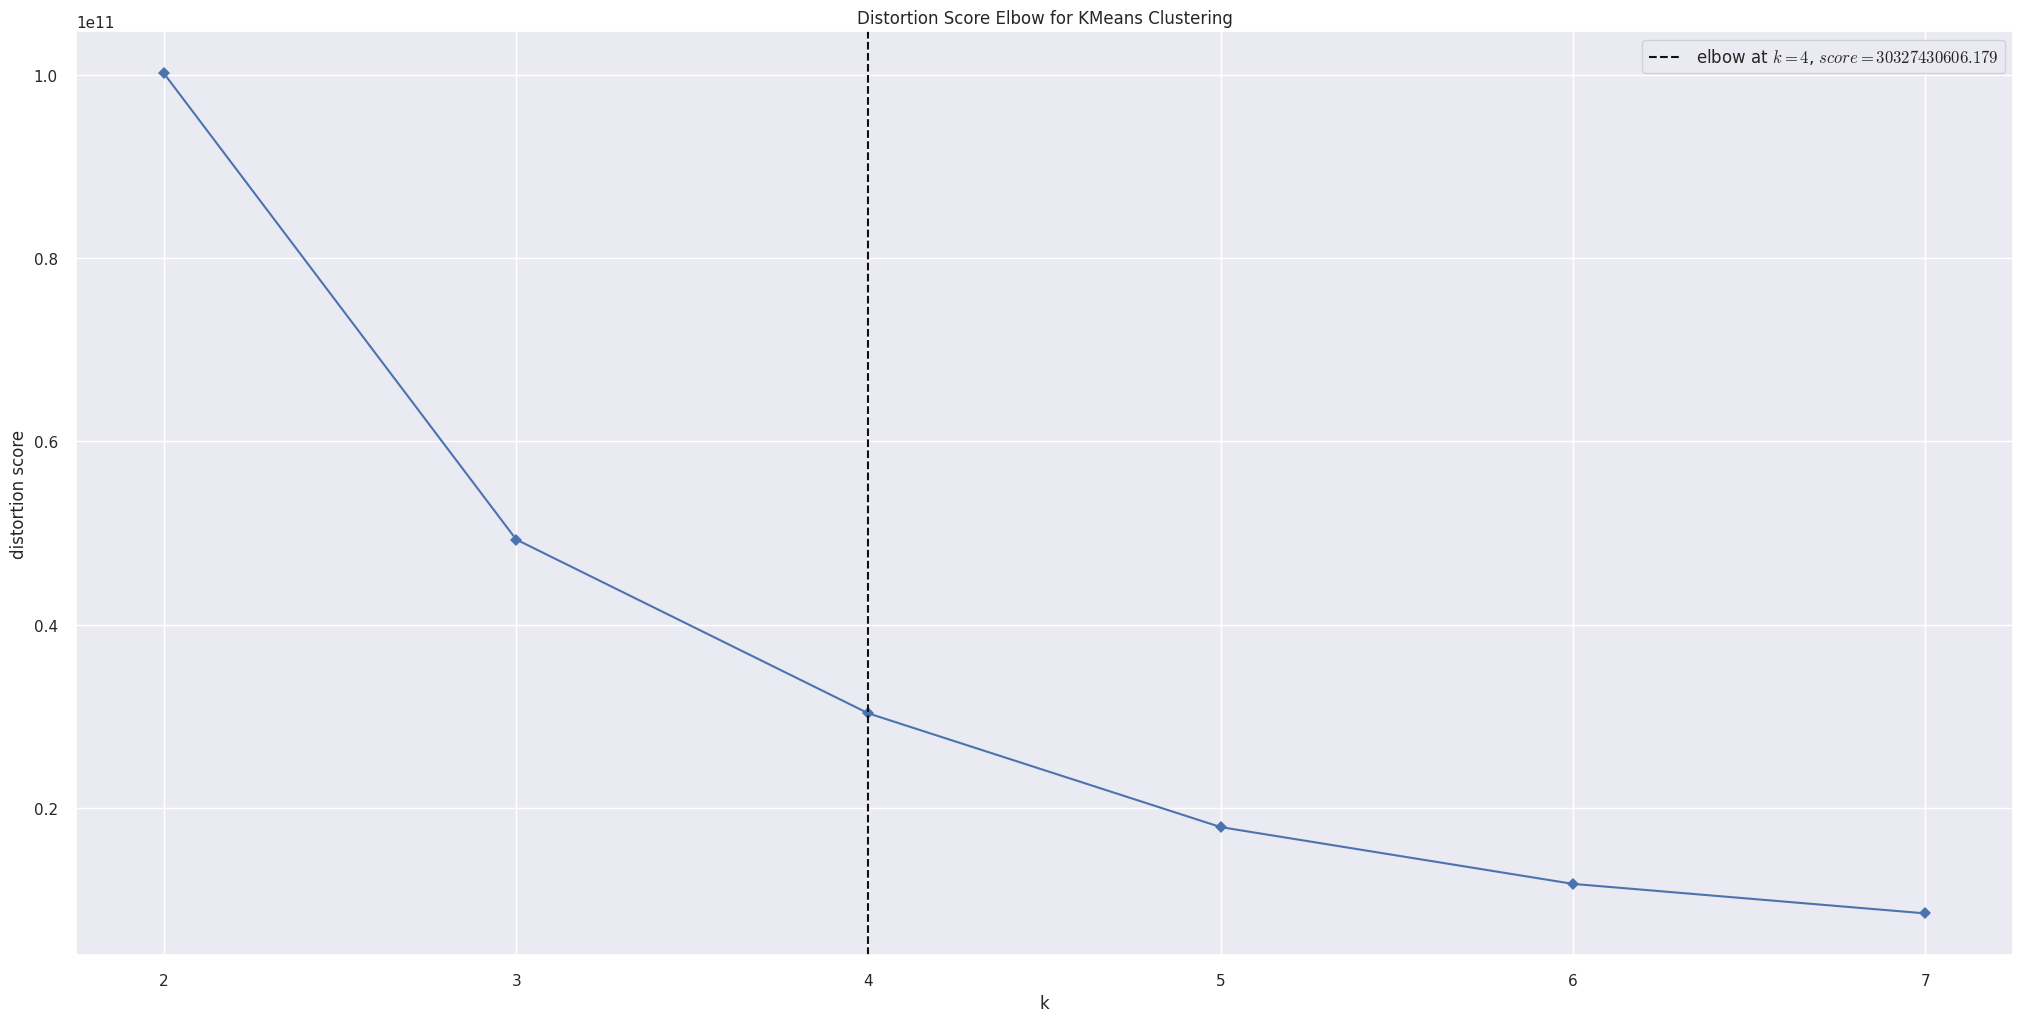

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
# Using Yellowbrick Visualizer
# Model definition
kmeans = KElbowVisualizer(c.KMeans(n_init=10), k=clusters, timings=False)

# Model training
kmeans.fit(df7)
kmeans.show()

## 7.2 Silhouette Score

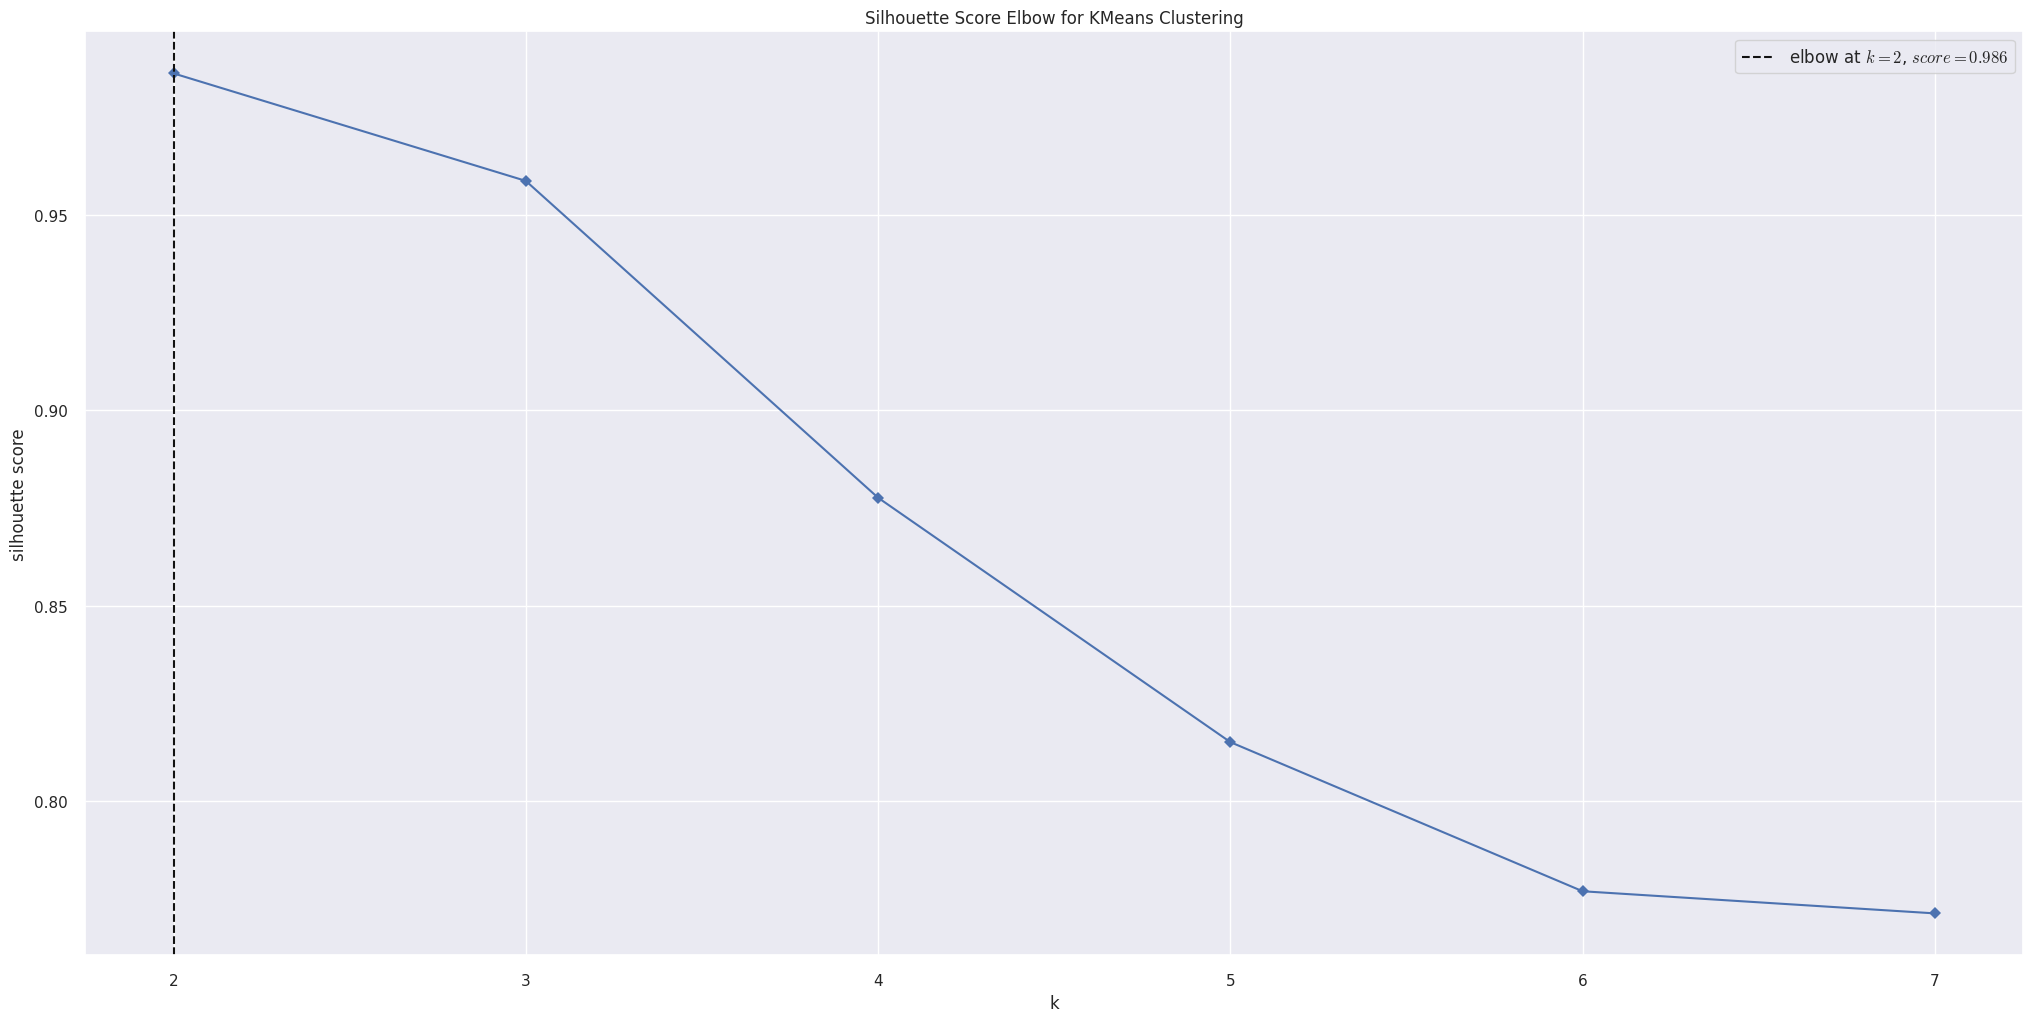

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [20]:
# Using Yellowbrick Visualizer
# Model definition
kmeans = KElbowVisualizer(c.KMeans(n_init=10), metric='silhouette', k=clusters, timings=False)

# Model training
kmeans.fit(df7)
kmeans.show()

## 7.3 Silhouette Analysis

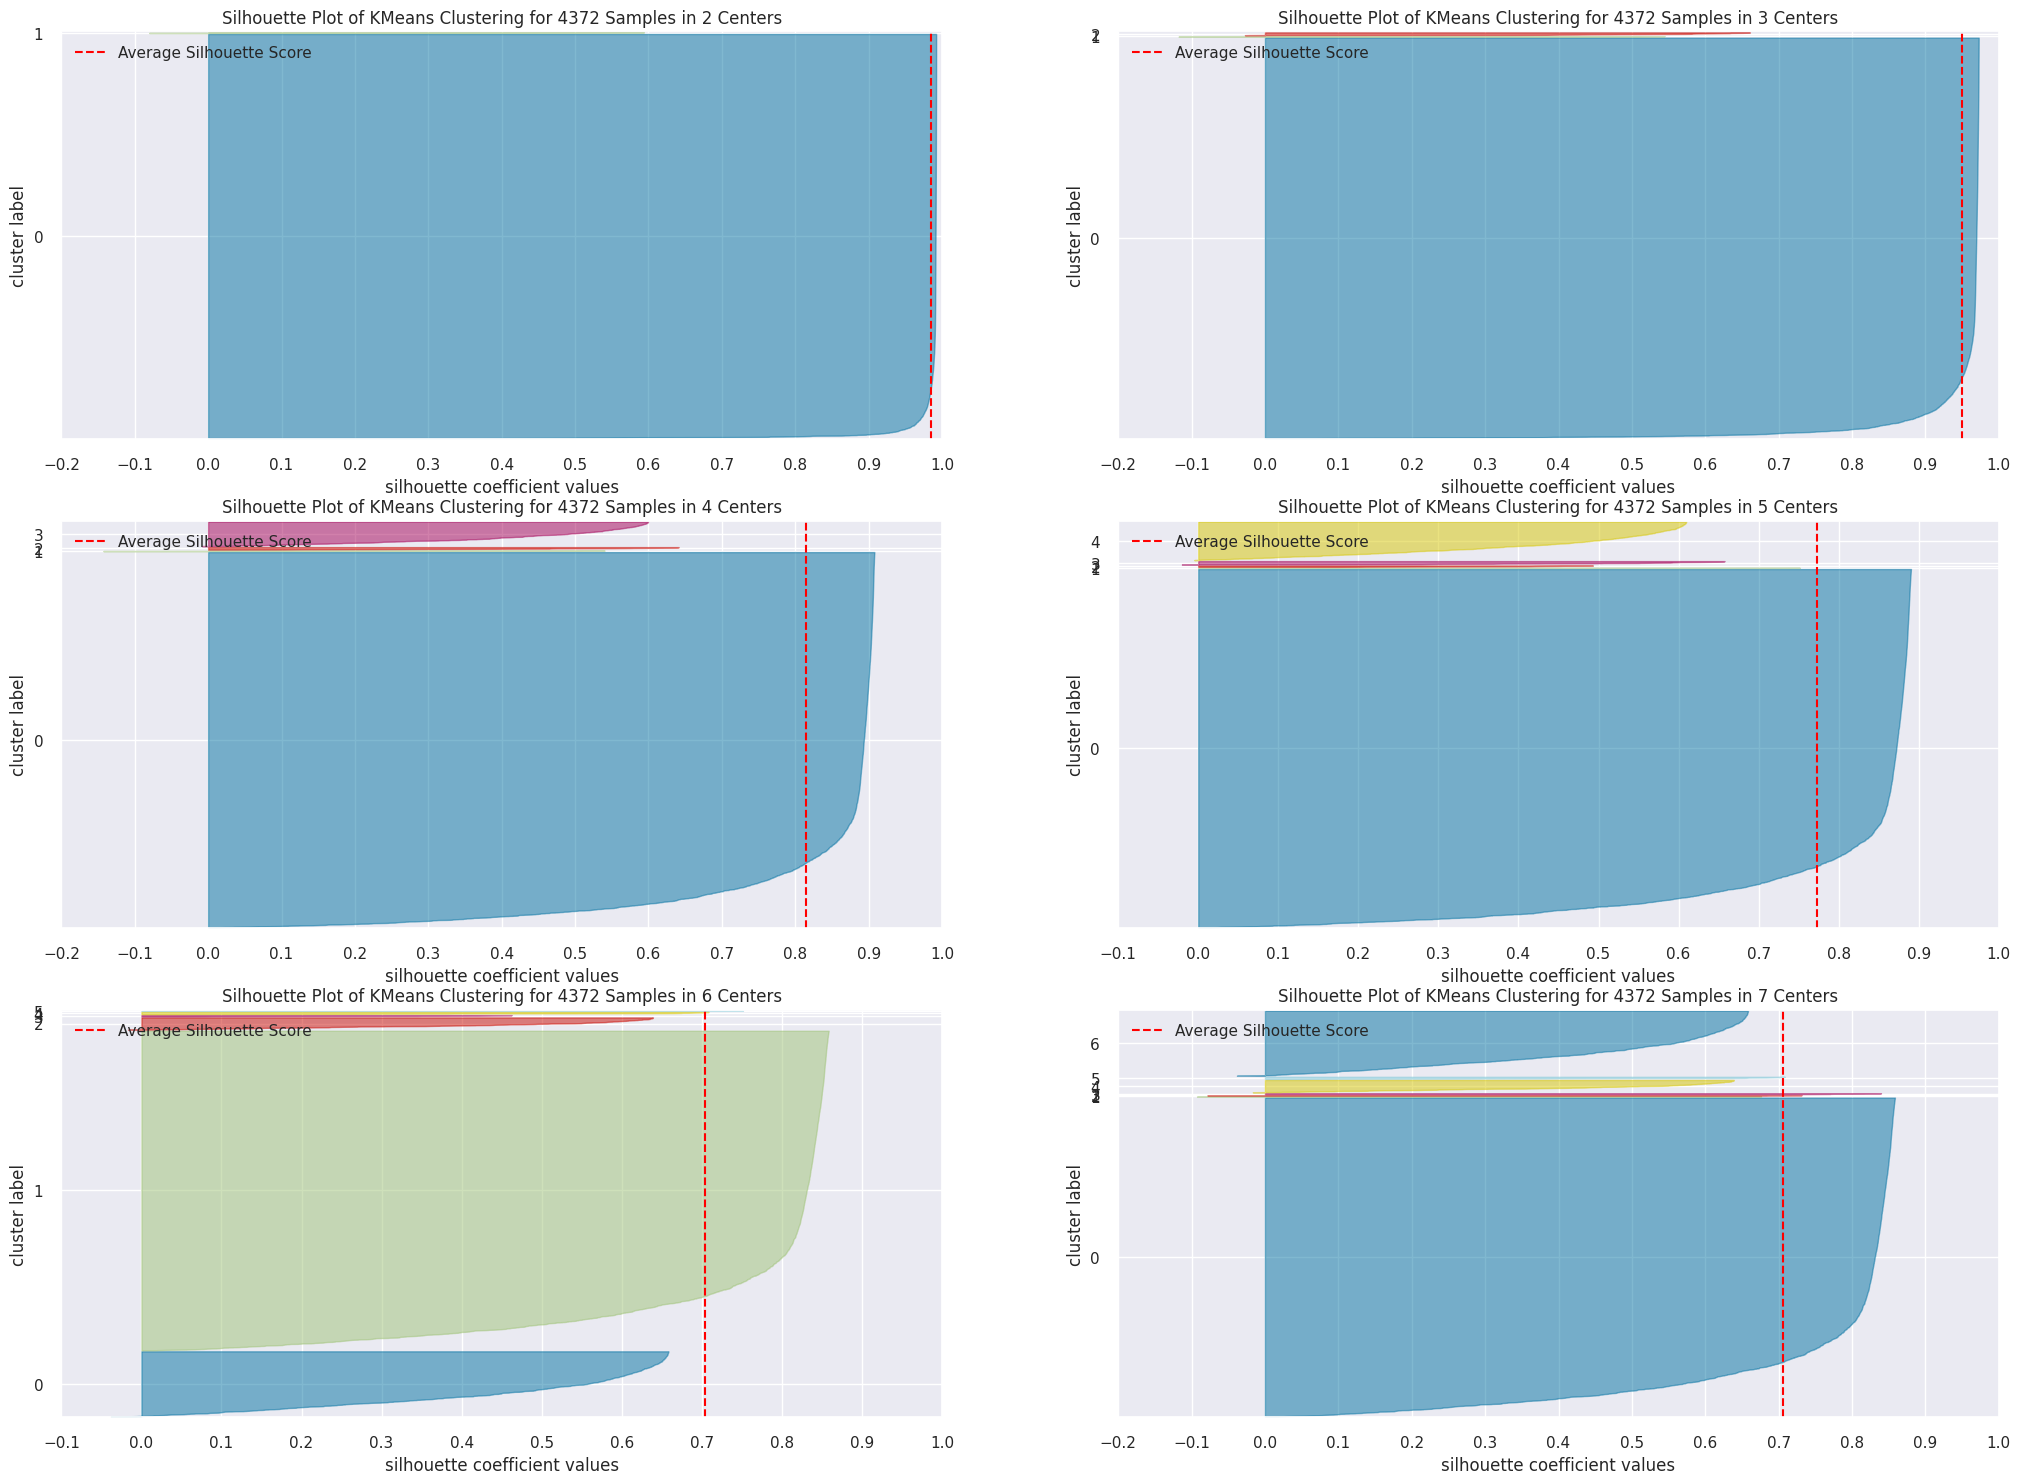

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))
                      
for k in clusters:
    # Model definition
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df7)
    visualizer.finalize()

# 8.0 MODEL TRAINING

In [27]:
df8 = df7.copy()

## 8.1 K-Means

In [22]:
# Model definition
k = 4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Model training
kmeans.fit(df8)

# Clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [23]:
# WSS (Within-Cluster Sum of Squares)
print(f'WSS value: {kmeans.inertia_}')

# SS (Silhouette Score)
print('Silhouette Score: {}'.format(m.silhouette_score(df8, labels, metric='euclidean')))

WSS value: 40056506734.60243
Silhouette Score: 0.8139972028952444


# 9.0 CLUSTER ANALYSIS

In [24]:
df9 = df_ref.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


In [ ]:
# Limited to 3 features
#fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
#fig.show()

## 9.1 Visualization Inspection

/home/matheus/.pyenv/versions/3.8.12/envs/pa005/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


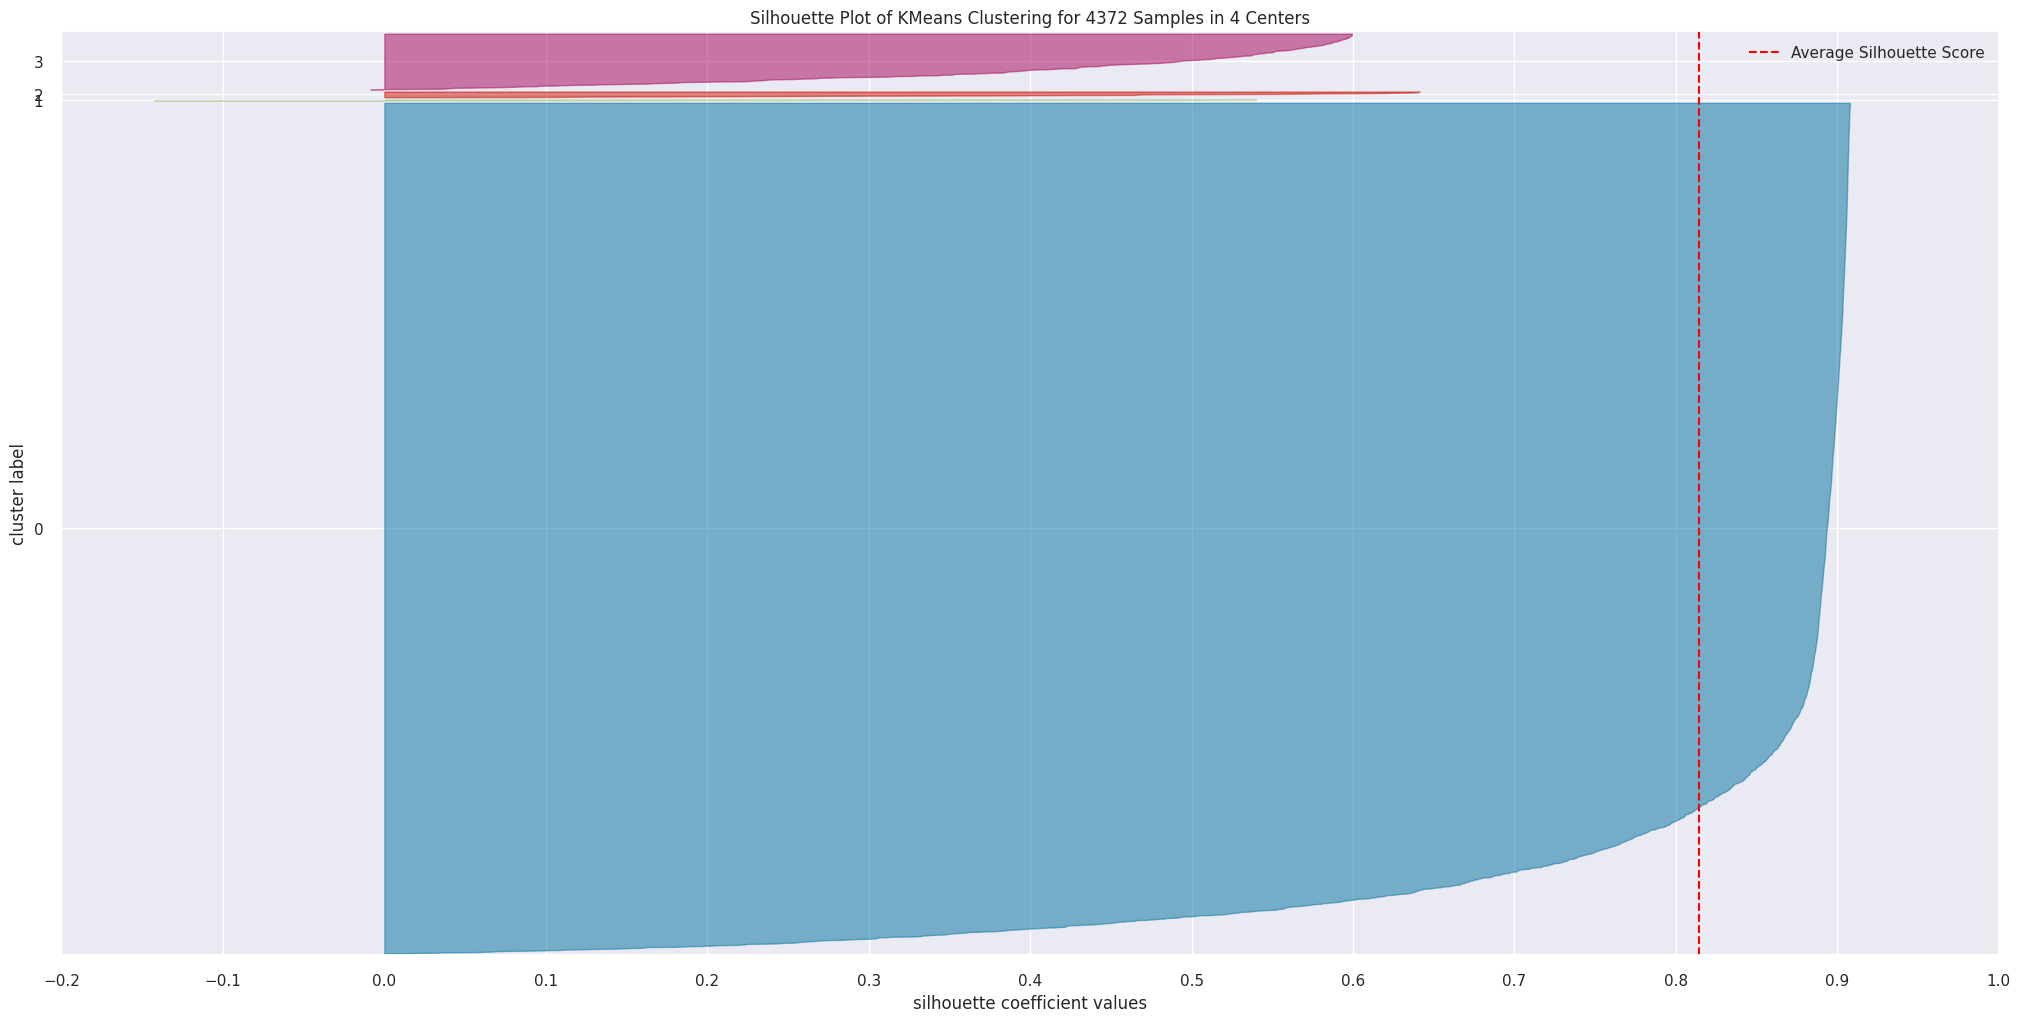

In [25]:
# Silhouette Analysis
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df8)
visualizer.finalize()

## 9.2 2d plot

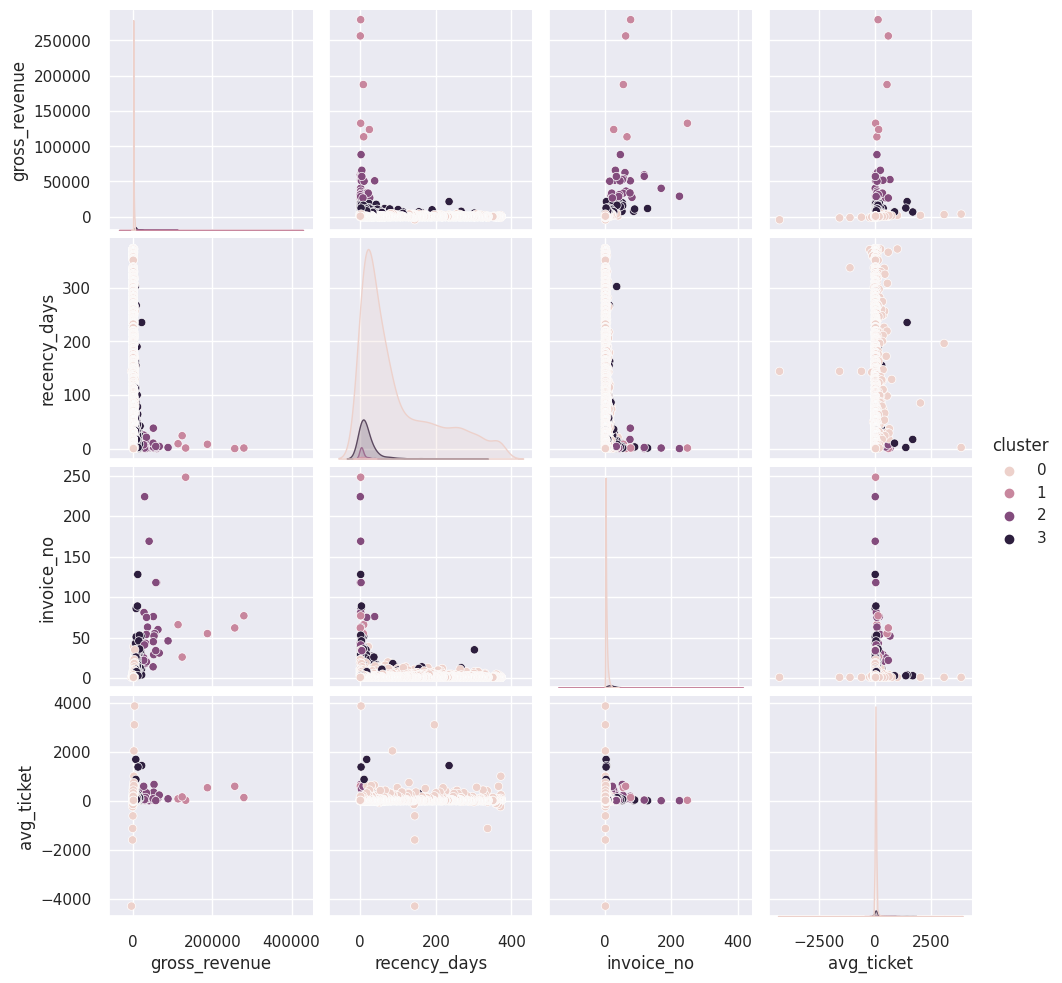

In [26]:
# Pair plot
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

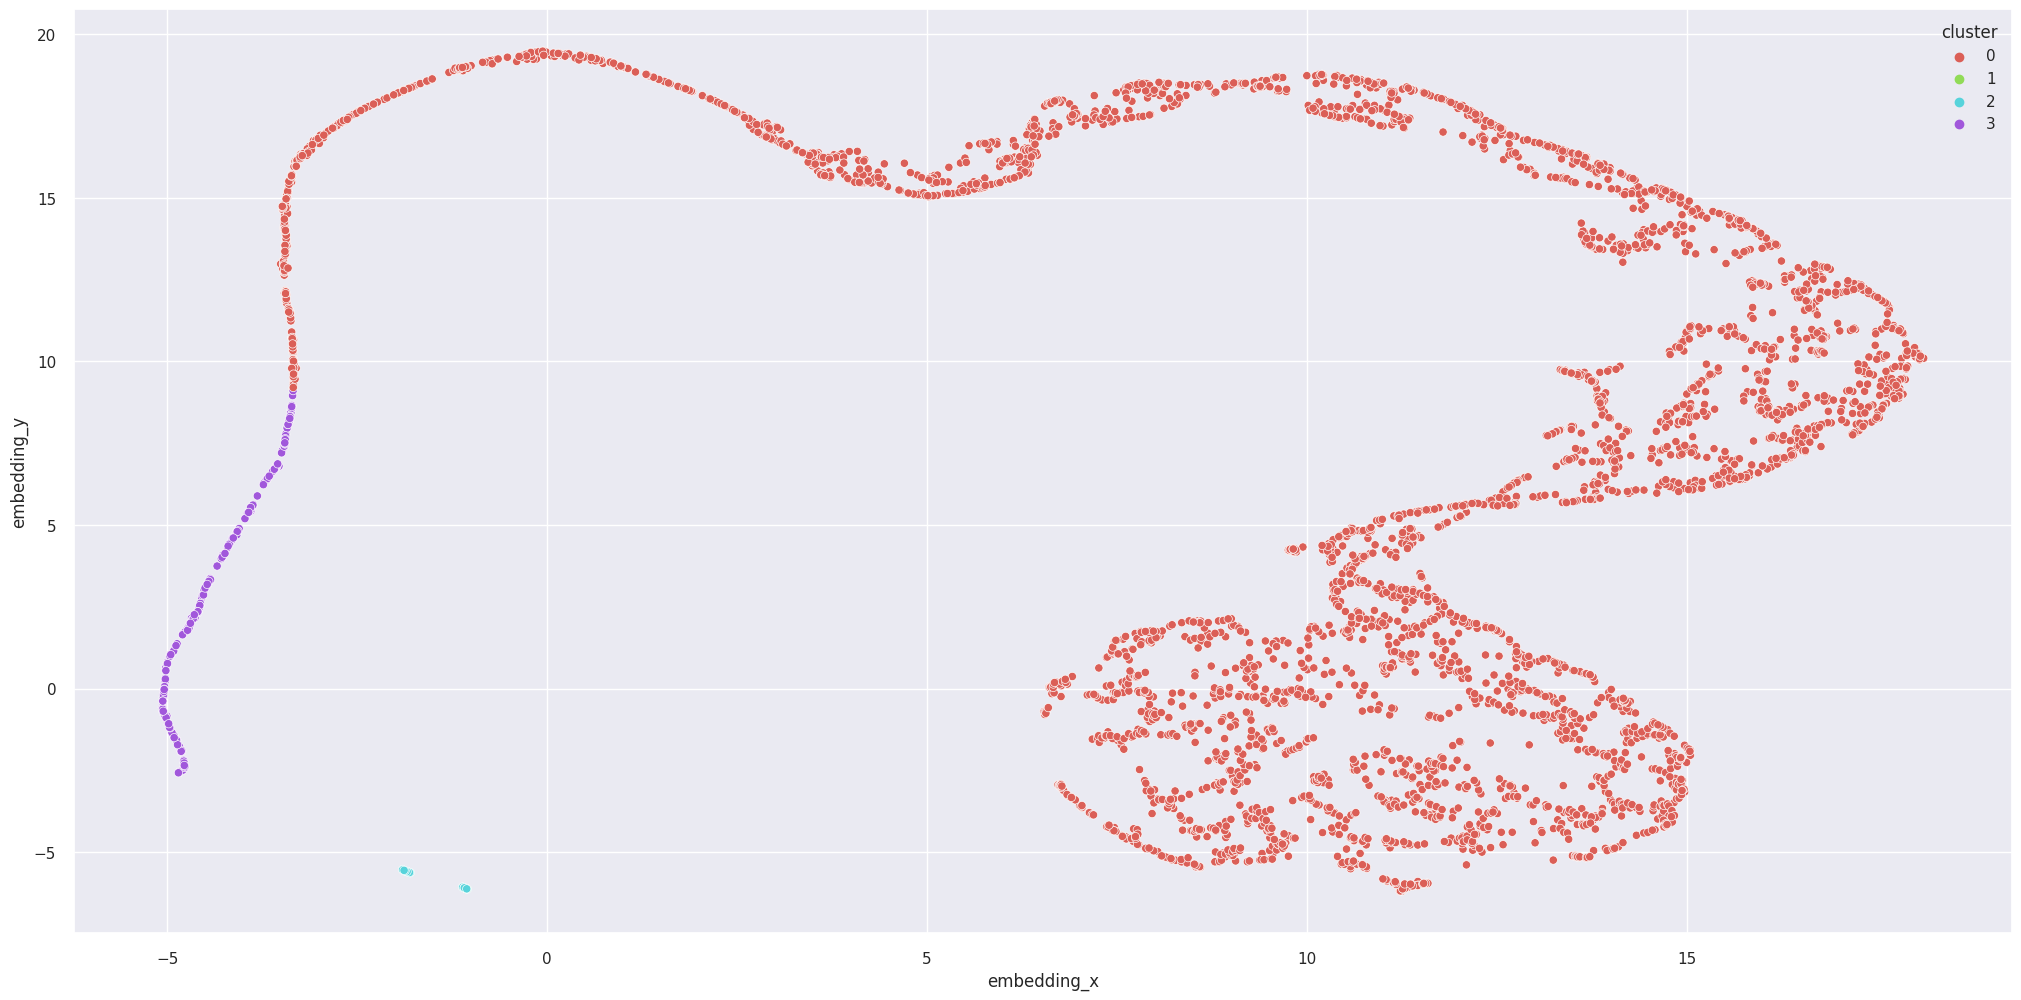

In [34]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df8)

# Embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# Plot
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz)

## 9.2 Cluster Profile

In [37]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = df_cluster['customer_id']/df_cluster['customer_id'].sum()*100

# Avg Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg Recency Days
df_avg_recency_days= df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg Invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['cluster', 'avg_ticket']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


### Cluster 01: (Candidato à Insider)
    - Número de customers: 6 (0,14% dos costumers)
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: £182.182,00
    - Ticket médio de: £253,62
    
### Cluster 02:
    - Número de customers: 28 (0,64% dos costumers)
    - Recência em média: 6 dias
    - Compras em média: 57 compras
    - Receita em média: £42.614,38
    - Ticket médio de: £162,86

### Cluster 03:
    - Número de customers: 267 (6,10% dos costumers)
    - Recência em média: 20 dias
    - Compras em média: 19 compras
    - Receita em média: £8.089,03
    - Ticket médio de: £62,78
    
### Cluster 04:
    - Número de customers: 4.071 (93,11% dos costumers)
    - Recência em média: 96 dias
    - Compras em média: 3 compras
    - Receita em média: £946,69
    - Ticket médio de: £25,36

# 10.0 DEPLOY TO PRODUCTION